<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#Qubit-parameters" data-toc-modified-id="Qubit-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Qubit parameters</a></span></li><li><span><a href="#Sweep-coupling" data-toc-modified-id="Sweep-coupling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sweep coupling</a></span></li><li><span><a href="#Calibrate-gate-time" data-toc-modified-id="Calibrate-gate-time-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calibrate gate time</a></span></li></ul></div>

# Preambles

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_transmon as transmon
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_2d
import plotting_settings
import scipy.linalg

# Qubit parameters

In [33]:
detuning = 190*1e-3 #GHz
omega1 = 5.23 #GHz
omega2 = 5.29
alpha1 = -0.273
alpha2 = -0.273
nlev = 3

qubit1 = transmon.TransmonSimple(omega_q = omega1, alpha = alpha1, nlev = nlev)
qubit2 = transmon.TransmonSimple(omega_q = omega2, alpha = alpha2, nlev = nlev)
JC = 0.005 #GHz
coupling_type = 'JC-rwa'
system = coupobj.CoupledObjects(qubit1, qubit2,
    [qubit1, qubit2, JC, coupling_type])

In [63]:
#Gate parameters
shape = 'gaussflattop'
T_gate = 400 #ns
T_rise = 100
drag = False
drag_coeff = 0.0

coupl = 54 #MHz
coupl_const = coupl*1e-3*2*np.pi
coupl_const = 14
delta_omega_d = 0.03 #GHz

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d
print (omega_d1)
print (omega_d2)
#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
U_t = gates_2d.evolution_operator_microwave(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

5.320413812651491
5.199586187348509


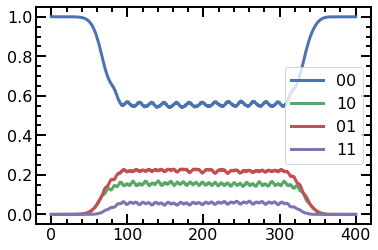

In [64]:
state_00 = system.eigvec('00')
state_01 = system.eigvec('01')
state_10 = system.eigvec('10')
state_11 = system.eigvec('11')

transition_00_00 = expect(state_00*state_00.dag(), U_t*state_00)
transition_00_10 = expect(state_10*state_10.dag(), U_t*state_00)
transition_00_01 = expect(state_01*state_01.dag(), U_t*state_00)
transition_00_11 = expect(state_11*state_11.dag(), U_t*state_00)

plt.plot(t_points, transition_00_00, label = '00')
plt.plot(t_points, transition_00_10, label = '10')
plt.plot(t_points, transition_00_01, label = '01')
plt.plot(t_points, transition_00_11, label = '11')
plt.legend()

# Sweep coupling

In [59]:
coupl_array = np.linspace(1,20,20)
trans_prob = np.zeros((len(coupl_array)))
for idx, coupl in enumerate(coupl_array):
#     coupl_const = coupl*1e-3 * 2 *np.pi
    coupl_const = coupl
    H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
    H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
    U_t = gates_2d.evolution_operator_microwave(system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)
    trans_prob[idx] = expect(state_10*state_10.dag(), U_t[-1]*state_01)
            

14.0


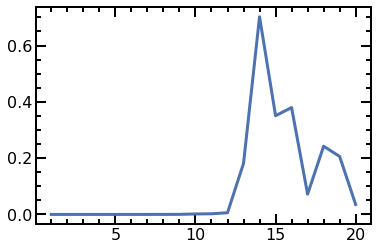

In [60]:
plt.plot(coupl_array, trans_prob)
print (coupl_array[np.argmax(trans_prob)])

# Calibrate gate time

In [61]:
# coupl = 14 #MHz
# coupl_const = coupl*1e-3*2*np.pi
coupl_const = 14
delta_omega_d = 0.03 #GHz

#Drive amplitude and frequency
omega_d1 = abs(system.freq('00', '01')) + delta_omega_d
omega_d2 = abs(system.freq('00', '10')) - delta_omega_d

#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive1 = coupl_const * (system.a(1) + system.a(1).dag())
H_drive2 = coupl_const * (system.a(0) + system.a(0).dag())
U_t = gates_2d.evolution_operator_microwave(
                system.H(), H_drive1, H_drive2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d1=omega_d1,omega_d2=omega_d2)

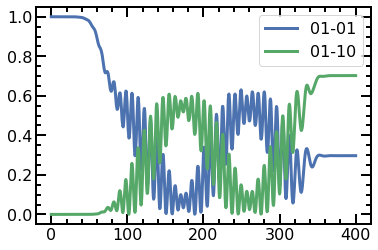

In [62]:
transition_01_10 = expect(state_10*state_10.dag(), U_t*state_01)
transition_01_01 = expect(state_01*state_01.dag(), U_t*state_01)
plt.plot(t_points, transition_01_01, label = '01-01')
plt.plot(t_points, transition_01_10, label = '01-10')
plt.legend()